# 資料轉換

In [43]:
# --- 安靜模式（可開關） ---
SILENCE_WARNINGS = True
if SILENCE_WARNINGS:
    import warnings, os
    from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

    # 常見良性警告
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    warnings.filterwarnings("ignore", message="X does not have valid feature names")  # 偶爾出現在 sklearn

    # xgboost 的訓練輸出
    warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

In [44]:
import re
import xml.etree.ElementTree as ET
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# === 依圖中說明設定 ===
# 經向先遞增（一列 67 個），再緯向遞增（總 120 列）
N_COLS = 67           # 經向欄數
N_ROWS = 120          # 緯向列數
DLON  = 0.03          # 經度解析度
DLAT  = 0.03          # 緯度解析度
LON0  = 120.00        # 左下角第一格點 經度
LAT0  = 21.88         # 左下角第一格點 緯度
INVALID = -999        # 無效值

EXPECTED_COUNT = N_COLS * N_ROWS

_float_pat = re.compile(r"[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?")

def extract_grid_values_from_xml(xml_path: str,
                                 expected_count: int = EXPECTED_COUNT) -> np.ndarray:
    """
    讀取 XML 並抽出溫度格點的一維序列（長度應為 expected_count）。
    做法：把整個 XML 轉成字串，用正則式撈出所有數字，
    再取「最後 expected_count 個」作為格點資料（常見情況：數據區在 XML 後段）。
    """
    xml_path = Path(xml_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()
    text = ET.tostring(root, encoding="unicode")
    nums = [float(x) for x in _float_pat.findall(text)]

    if len(nums) < expected_count:
        raise ValueError(
            f"檔案中找到的數字只有 {len(nums)} 個，小於預期 {expected_count}。"
            " 請確認 XML 是否完整，或調整 N_ROWS/N_COLS 設定。"
        )

    values = np.asarray(nums[-expected_count:], dtype=float)  # 取最後一段
    return values

def build_lonlat_grid(n_cols=N_COLS, n_rows=N_ROWS,
                      lon0=LON0, lat0=LAT0, dlon=DLON, dlat=DLAT, decimals=2):
    """
    依「經向先遞增、再緯向遞增」建立對應座標網格（與資料一一對齊）。
    回傳展平成一維的 (lon_flat, lat_flat)。
    """
    lons = np.round(lon0 + np.arange(n_cols) * dlon, decimals)
    lats = np.round(lat0 + np.arange(n_rows) * dlat, decimals)
    Lon, Lat = np.meshgrid(lons, lats)
    return Lon.ravel(), Lat.ravel()


In [46]:
# === 把這個改成你的檔案路徑 ===
XML_FILE = r"C:\hsiang\machine learning\2025_machine_learning\Week_4\O-A0038-003.xml"

# 讀取格點溫度並重塑為 (N_ROWS, N_COLS)
vals_flat = extract_grid_values_from_xml(XML_FILE, EXPECTED_COUNT)
vals = vals_flat.reshape(N_ROWS, N_COLS)          # 每列 67 個，總 120 列
lon_flat, lat_flat = build_lonlat_grid()

# ---- 組成一張總表（含溫度值）----
df_all = pd.DataFrame({
    "lon": lon_flat,
    "lat": lat_flat,
    "val": vals.ravel()
})

# (a) 分類資料集：valid -> 1, invalid(-999) -> 0
df_cls = df_all[["lon", "lat"]].copy()
df_cls["label"] = (df_all["val"] != INVALID).astype(int)

# (b) 回歸資料集：只保留有效值
df_reg = df_all.loc[df_all["val"] != INVALID, ["lon", "lat", "val"]].rename(columns={"val": "value"})

# ---- 輸出 CSV ----
base = Path(XML_FILE).stem
out_cls = f"{base}_classification.csv"
out_reg = f"{base}_regression.csv"
df_cls.to_csv(out_cls, index=False)
df_reg.to_csv(out_reg, index=False)

print("完成！")
print(f"分類資料集：{out_cls}（欄位：lon, lat, label）")
print(f"回歸資料集：{out_reg}（欄位：lon, lat, value）")

# 印出前幾列
display(df_cls.head(10))
display(df_reg.head(10))


完成！
分類資料集：O-A0038-003_classification.csv（欄位：lon, lat, label）
回歸資料集：O-A0038-003_regression.csv（欄位：lon, lat, value）


,lon,lat,label
0,120.00,21.88,0
1,120.03,21.88,0
2,120.06,21.88,0
3,120.09,21.88,0
4,120.12,21.88,0
5,120.15,21.88,0
6,120.18,21.88,0
7,120.21,21.88,0
8,120.24,21.88,0
9,120.27,21.88,0


,lon,lat,value
158,120.72,21.94,28.1
221,120.60,21.97,28.6
222,120.63,21.97,28.6
223,120.66,21.97,27.8
224,120.69,21.97,26.5
225,120.72,21.97,28.7
288,120.60,22.00,28.6
289,120.63,22.00,28.6
290,120.66,22.00,28.1
291,120.69,22.00,28.5


# EDA

In [47]:
CLS_CSV = r"C:\hsiang\machine learning\2025_machine_learning\Week_4\O-A0038-003_classification.csv"
REG_CSV = r"C:\hsiang\machine learning\2025_machine_learning\Week_4\O-A0038-003_regression.csv"

df_cls = pd.read_csv(CLS_CSV)
df_reg = pd.read_csv(REG_CSV)

# 建議把經緯度固定到小數第 2 位，避免 21.9399999998 這種顯示
df_cls["lon"] = df_cls["lon"].round(2)
df_cls["lat"] = df_cls["lat"].round(2)
df_reg["lon"] = df_reg["lon"].round(2)
df_reg["lat"] = df_reg["lat"].round(2)

df_cls.head(), df_reg.head()

(      lon    lat  label
 0  120.00  21.88      0
 1  120.03  21.88      0
 2  120.06  21.88      0
 3  120.09  21.88      0
 4  120.12  21.88      0,
       lon    lat  value
 0  120.72  21.94   28.1
 1  120.60  21.97   28.6
 2  120.63  21.97   28.6
 3  120.66  21.97   27.8
 4  120.69  21.97   26.5)

In [48]:
def grid_info(df):
    n = len(df)
    n_lon = df["lon"].nunique()
    n_lat = df["lat"].nunique()
    dup = df.duplicated(["lon","lat"]).sum()
    print(f"筆數={n:,}；lon 種類={n_lon}；lat 種類={n_lat}；重複座標筆數={dup}")
    print(f"lon 範圍: {df['lon'].min()} ~ {df['lon'].max()}")
    print(f"lat 範圍: {df['lat'].min()} ~ {df['lat'].max()}")
    return n_lat, n_lon

print("【Classification】"); cls_shape = grid_info(df_cls)
print("\n【Regression】");    reg_shape = grid_info(df_reg)

# 若你期望固定為 120x67，可檢查：
# assert cls_shape == (120, 67), f"Classification 網格不是 120x67: {cls_shape}"
# 若回歸集有剔除無效值，形狀不一定完整。

【Classification】
筆數=8,040；lon 種類=67；lat 種類=120；重複座標筆數=0
lon 範圍: 120.0 ~ 121.98
lat 範圍: 21.88 ~ 25.45

【Regression】
筆數=3,499；lon 種類=67；lat 種類=113；重複座標筆數=0
lon 範圍: 120.0 ~ 121.98
lat 範圍: 21.94 ~ 25.45


Classification 資料集 EDA

Label counts:
 label
invalid(-999)    4541
valid            3499
Name: count, dtype: int64
Label ratio:
 label
invalid(-999)    0.565
valid            0.435
Name: count, dtype: float64


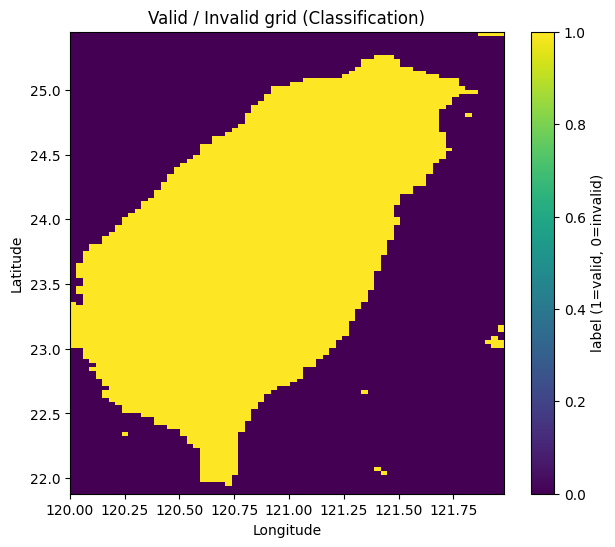

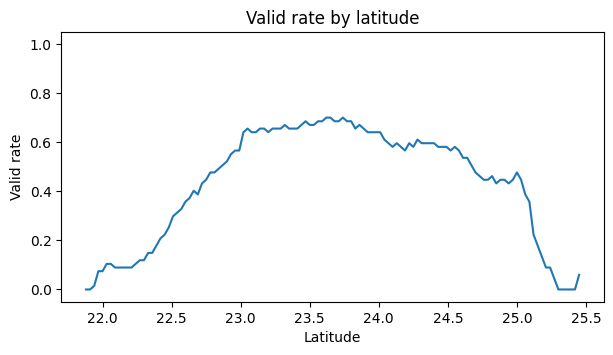

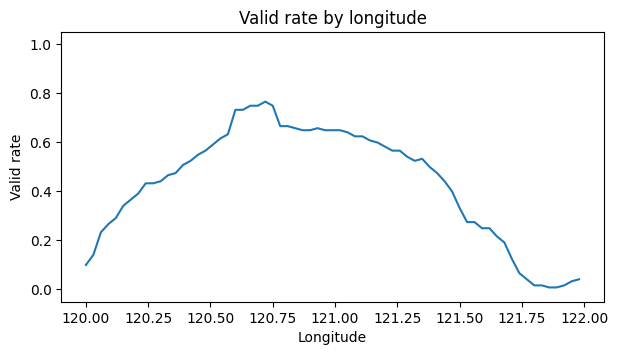

In [49]:
# (a) 標籤分布
counts = df_cls["label"].value_counts().rename({0:"invalid(-999)", 1:"valid"})
ratio = (counts / counts.sum()).round(4)
print("Label counts:\n", counts)
print("Label ratio:\n", ratio)

# (b) 以格網方式畫「有效/無效」空間分布
# 轉成 pivot：index=lat, columns=lon, value=label
grid_lbl = df_cls.pivot_table(index="lat", columns="lon", values="label", aggfunc="mean")

plt.figure(figsize=(7,6))
extent = [grid_lbl.columns.min(), grid_lbl.columns.max(), grid_lbl.index.min(), grid_lbl.index.max()]
plt.imshow(grid_lbl.values, origin="lower", aspect="auto", extent=extent)
plt.colorbar(label="label (1=valid, 0=invalid)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Valid / Invalid grid (Classification)")
plt.show()

# (c) 每一緯度帶的有效比例（看是否有緯向系統性缺值）
lat_valid_rate = df_cls.groupby("lat")["label"].mean()
plt.figure(figsize=(7,3.5))
lat_valid_rate.plot()
plt.ylim(-0.05, 1.05)
plt.xlabel("Latitude"); plt.ylabel("Valid rate")
plt.title("Valid rate by latitude")
plt.show()

# (d) 每一經度帶的有效比例
lon_valid_rate = df_cls.groupby("lon")["label"].mean()
plt.figure(figsize=(7,3.5))
lon_valid_rate.plot()
plt.ylim(-0.05, 1.05)
plt.xlabel("Longitude"); plt.ylabel("Valid rate")
plt.title("Valid rate by longitude")
plt.show()

Regression 資料集 EDA（只含有效值）

count    3499.000
mean       21.567
std         6.183
min        -1.900
1%          2.998
5%          8.100
25%        18.400
50%        24.400
75%        25.800
95%        27.800
99%        28.500
max        30.000
Name: value, dtype: float64


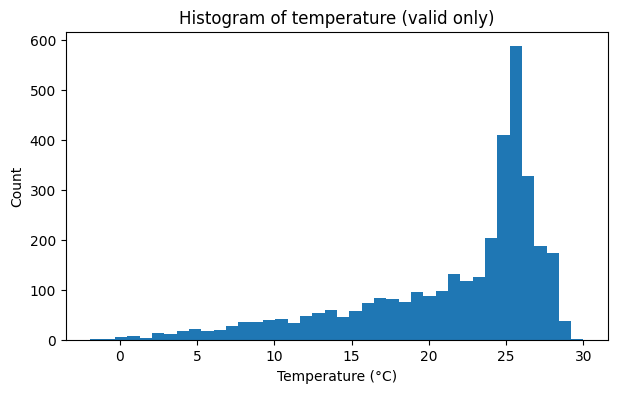

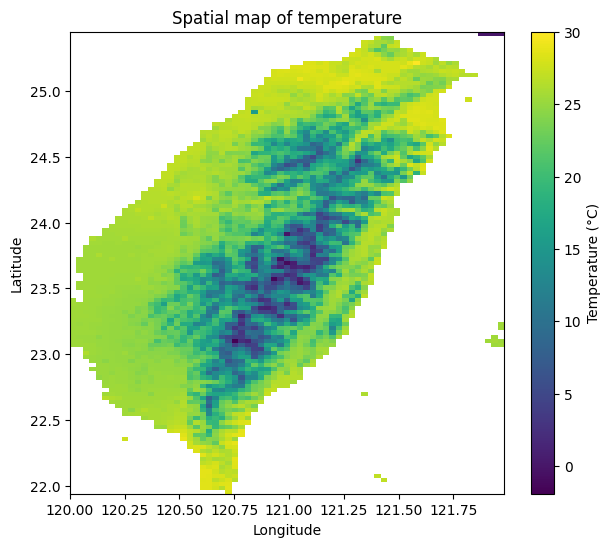

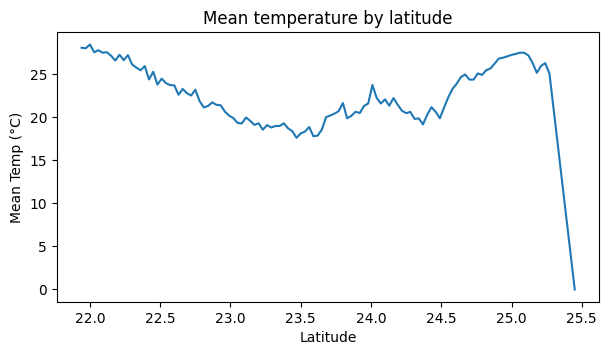

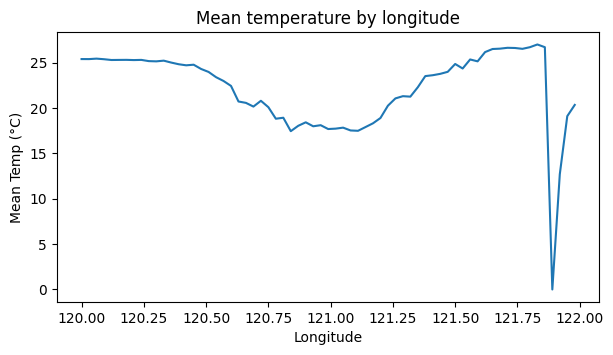

         lon    lat  value
lon    1.000  0.565 -0.137
lat    0.565  1.000  0.123
value -0.137  0.123  1.000


In [50]:
# (a) 基本統計
desc = df_reg["value"].describe(percentiles=[.01,.05,.25,.5,.75,.95,.99])
print(desc)

# (b) 直方圖
plt.figure(figsize=(7,4))
plt.hist(df_reg["value"], bins=40)
plt.xlabel("Temperature (°C)"); plt.ylabel("Count")
plt.title("Histogram of temperature (valid only)")
plt.show()

# (c) 溫度的空間分布（熱度圖）
grid_val = df_reg.pivot_table(index="lat", columns="lon", values="value", aggfunc="mean")

plt.figure(figsize=(7,6))
extent = [grid_val.columns.min(), grid_val.columns.max(), grid_val.index.min(), grid_val.index.max()]
im = plt.imshow(grid_val.values, origin="lower", aspect="auto", extent=extent)
plt.colorbar(im, label="Temperature (°C)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Spatial map of temperature")
plt.show()

# (d) 緯向/經向的平均溫度剖面（看是否有梯度）
lat_prof = df_reg.groupby("lat")["value"].mean()
lon_prof = df_reg.groupby("lon")["value"].mean()

plt.figure(figsize=(7,3.5))
lat_prof.plot()
plt.xlabel("Latitude"); plt.ylabel("Mean Temp (°C)")
plt.title("Mean temperature by latitude")
plt.show()

plt.figure(figsize=(7,3.5))
lon_prof.plot()
plt.xlabel("Longitude"); plt.ylabel("Mean Temp (°C)")
plt.title("Mean temperature by longitude")
plt.show()

# (e) 經緯度與溫度的相關係數（線性趨勢粗看）
print(df_reg[["lon","lat","value"]].corr(numeric_only=True))

經度的平均溫度掉到 0 幾乎可以確定是某個經度欄位裡有 0°C 的有效值（可能是原始檔裡真的有 0、或邊界/海陸遮罩用 0 當特殊值），而且那個經度下可用點數不多，平均就被拉到接近 0。

下面幾行確認「是哪一個經度、點數多少、最小值是不是 0」：

In [51]:
g = (df_reg
     .groupby('lon')
     .agg(mean=('value','mean'),
          count=('value','size'),
          min=('value','min'),
          max=('value','max'))
     .sort_index())

# 找出可疑經度（平均太低或最小值<=0）
sus = g[(g['mean'] < 5) | (g['min'] <= 0)]
display(sus)

# 看那些經度上的原始點
bad_lons = sus.index.tolist()
display(df_reg[df_reg['lon'].isin(bad_lons)].sort_values(['lon','lat']).head(20))

# 直接列出 value==0 的點
display(df_reg[df_reg['value'] == 0])

,mean,count,min,max
lon,,,,
120.75,20.088,90,-1.90,28.8
120.93,17.984,79,-1.30,28.0
120.96,18.105,78,-0.54,28.2
120.99,17.682,78,-1.10,28.3
121.89,0.000,1,0.00,0.0
121.92,12.700,2,0.00,25.4
121.95,19.100,4,0.00,25.7
121.98,20.340,5,0.00,25.6


,lon,lat,value
16,120.75,22.03,26.5
23,120.75,22.06,27.4
30,120.75,22.09,26.7
36,120.75,22.12,28.4
42,120.75,22.15,28.6
48,120.75,22.18,28.7
54,120.75,22.21,27.1
61,120.75,22.24,27.6
69,120.75,22.27,28.1
77,120.75,22.30,28.8


,lon,lat,value
3495,121.89,25.45,0.0
3496,121.92,25.45,0.0
3497,121.95,25.45,0.0
3498,121.98,25.45,0.0


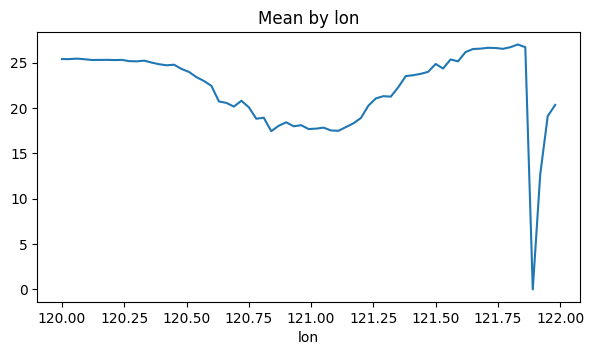

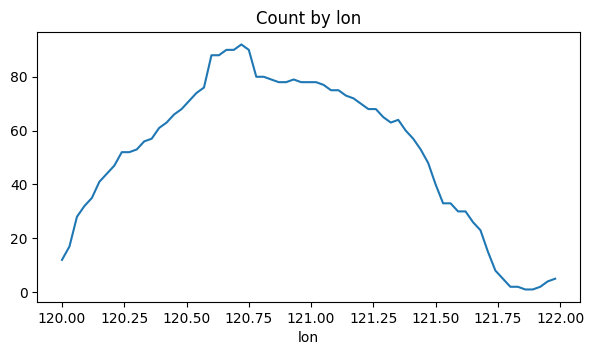

In [52]:
g['mean'].plot(figsize=(7,3.5), title='Mean by lon'); plt.show()
g['count'].plot(figsize=(7,3.5), title='Count by lon'); plt.show()

In [53]:
# 把回歸集的座標標記回分類集，確認有 value 的點 label 皆為 1
key = ["lon","lat"]
has_value = pd.Series(1, index=pd.MultiIndex.from_frame(df_reg[key]))
df_cls["should_be_valid"] = df_cls.set_index(key).index.map(lambda idx: int(idx in has_value.index))
cm = pd.crosstab(df_cls["label"], df_cls["should_be_valid"], rownames=["label"], colnames=["has_value"])
print(cm)
# 理想情況：should_be_valid=1 的列中，label 皆為 1

has_value     0     1
label                
0          4541     0
1             0  3499


- `has_value=1` 的 3499 個點，其 label 全是 1（完全一致）。

- `has_value=0` 的 4541 個點，其 label 全是 0。

- 總格點數 4541+3499=8040 (= 120×67)，轉換邏輯正確。

- 有效覆蓋率 = 3499 / 8040 ≈ 43.5%；其餘 56.5% 是缺測（-999）。

原始網格在東北邊界只剩極少點是有效值，且那些點的 value=0（`sus` 表與 `df_reg[df_reg.value==0]` 證實了）。在來源沒說明 0 的意義時，建議用一個「保守的資料清理流程」，同時保留可追溯性與靈敏度分析。

1) 設定 QC 規則

- R0：來源無效值（已去除 -999）

- R1：value==0 → 視為無效（暫時）

- R2：溫度合理範圍之外（例如 [-10, 45]；可依季節/資料型態調整）

- R3：樣本數太少的經度/緯度（避免被 1～2 個點影響）：count_by_lon < MIN_COUNT 或 valid_rate_by_lat < MIN_RATE

In [54]:
# 既有常數
N_ROWS = 120
N_COLS = 67

# ---- 參數（可調整）----
TMIN, TMAX = -10, 45       # 合理溫度範圍
MIN_COVERAGE = 0.1         # 例如：覆蓋率 < 15% 視為支援度不足

# 先算支援度（用回歸集的實際有效點數）
# 計算覆蓋率（兩個方向都用比例，維持一致）
cnt_by_lon = df_reg.groupby('lon').size()
cnt_by_lat = df_reg.groupby('lat').size()

cov_by_lon = cnt_by_lon / N_ROWS
cov_by_lat = cnt_by_lat / N_COLS

bad_lon = cov_by_lon[cov_by_lon < MIN_COVERAGE].index
bad_lat = cov_by_lat[cov_by_lat < MIN_COVERAGE].index

# 為回歸集建立 QC 標籤
df_reg_qc = df_reg.copy()
df_reg_qc['qc_reason'] = ''

df_reg_qc.loc[df_reg_qc['value'] == 0, 'qc_reason'] += '|R1_zero'
df_reg_qc.loc[(df_reg_qc['value'] < -10) | (df_reg_qc['value'] > 45), 'qc_reason'] += '|R2_range'
df_reg_qc.loc[df_reg_qc['lon'].isin(bad_lon), 'qc_reason'] += '|R3_lon_low_coverage'
df_reg_qc.loc[df_reg_qc['lat'].isin(bad_lat), 'qc_reason'] += '|R3_lat_low_coverage'

# 乾淨版（把任何有 qc_reason 的點先當成無效）
df_reg_clean = df_reg_qc[df_reg_qc['qc_reason'] == ''].copy()

print("原始有效點數：", len(df_reg))
print("清理後有效點數：", len(df_reg_clean))
print("各類被排除筆數：")
print(df_reg_qc['qc_reason'].value_counts().sort_index())

原始有效點數： 3499
清理後有效點數： 3413
各類被排除筆數：
qc_reason
                                                    3413
|R1_zero|R3_lon_low_coverage|R3_lat_low_coverage       4
|R3_lat_low_coverage                                  56
|R3_lon_low_coverage                                  26
Name: count, dtype: int64


In [55]:
# 把被排除的座標標記回分類集，令 label=0
drop_idx = pd.MultiIndex.from_frame(df_reg_qc[df_reg_qc['qc_reason'] != ''][['lon','lat']])
df_cls_clean = df_cls.copy()
is_drop = df_cls_clean.set_index(['lon','lat']).index.isin(drop_idx)
df_cls_clean.loc[is_drop, 'label'] = 0

# 交叉驗證（理想：列 only 在對角）
key = ['lon','lat']
has_value = pd.Series(1, index=pd.MultiIndex.from_frame(df_reg_clean[key]))
df_cls_clean['should_be_valid'] = df_cls_clean.set_index(key).index.map(lambda i: int(i in has_value.index))
print(pd.crosstab(df_cls_clean['label'], df_cls_clean['should_be_valid']))

should_be_valid     0     1
label                      
0                4627     0
1                   0  3413


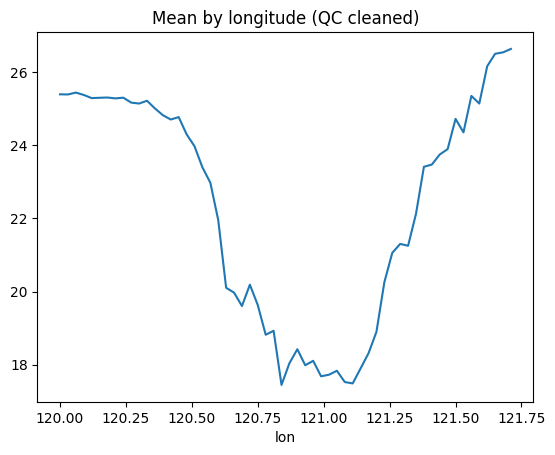

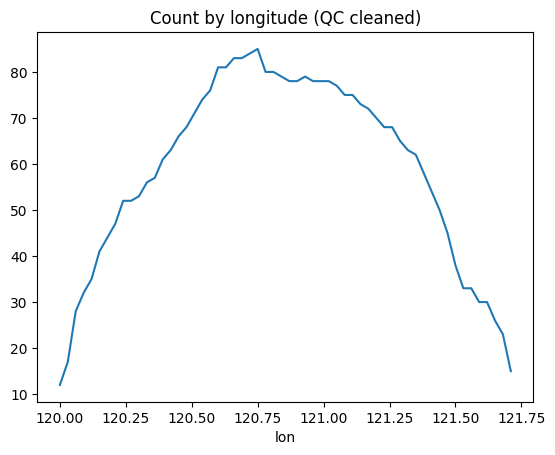

In [56]:
lon_prof = df_reg_clean.groupby('lon')['value'].mean()
cnt_prof = df_reg_clean.groupby('lon')['value'].size()

lon_prof.plot(title='Mean by longitude (QC cleaned)'); plt.show()
cnt_prof.plot(title='Count by longitude (QC cleaned)'); plt.show()

In [57]:
df_reg_qc.to_csv("regression_with_qc_reason.csv", index=False)  # 各點為何被排除
df_reg_clean.to_csv("regression_clean.csv", index=False)
df_cls_clean.to_csv("classification_clean.csv", index=False)

最後 data

In [58]:
df_cls = pd.read_csv("classification_clean.csv")
df_reg = pd.read_csv("regression_clean.csv")

# 1) 基本統計 & 極端值
print(df_reg["value"].describe(percentiles=[.01,.05,.95,.99]))

# 2) 是否仍有 0 / 非常離群值
print("zeros:", (df_reg["value"]==0).sum())
z = (df_reg["value"]-df_reg["value"].mean())/df_reg["value"].std()
print(">|3|σ outliers:", (np.abs(z)>3).sum())

# 3) 經緯覆蓋是否合理（比例）
N_ROWS, N_COLS = 120, 67
cov_lon = df_reg.groupby("lon").size()/N_ROWS
cov_lat = df_reg.groupby("lat").size()/N_COLS
print(cov_lon.min(), cov_lat.min())

# 4) （可選）空間自相關（Moran's I 的 8-鄰近近似）
from sklearn.neighbors import kneighbors_graph
X = df_reg[["lon","lat"]].values
y = df_reg["value"].values
W = kneighbors_graph(X, n_neighbors=8, mode="connectivity", include_self=False)
y0 = y - y.mean()
I = (len(y)/W.sum()) * (y0 @ (W @ y0)) / (y0 @ y0)
print("Approx Moran's I:", I)   # >0 代表有正的空間自相關（正常）

count    3413.000
mean       21.466
std         6.159
min        -1.900
1%          3.112
5%          8.100
50%        24.300
95%        27.700
99%        28.400
max        30.000
Name: value, dtype: float64
zeros: 0
>|3|σ outliers: 31
0.1 0.1044776119402985
Approx Moran's I: 0.8513801938213674


# 模型訓練

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             mean_absolute_error, mean_squared_error, r2_score)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from joblib import dump

try:
    from xgboost import XGBClassifier, XGBRegressor
    has_xgb = True
except Exception as e:
    print("⚠️ xgboost 未安裝，將跳過 XGBoost：", e)
    has_xgb = False

from sklearn.metrics import mean_squared_error
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y_true, y_pred):
        return _rmse(y_true, y_pred)
except Exception:
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

In [83]:
# ---- 資料 ----
df_cls = pd.read_csv("classification_clean.csv")
df_reg = pd.read_csv("regression_clean.csv")
Xc, yc = df_cls[["lon","lat"]].values, df_cls["label"].values
Xr, yr = df_reg[["lon","lat"]].values, df_reg["value"].values

# --- 台灣網格規格（固定邊界法會用到） ---
N_COLS, N_ROWS = 67, 120
LON0, LAT0 = 120.00, 21.88
DLON, DLAT = 0.03, 0.03
LON_MIN, LON_MAX = LON0, LON0 + (N_COLS-1)*DLON
LAT_MIN, LAT_MAX = LAT0, LAT0 + (N_ROWS-1)*DLAT

N_LON, N_LAT = 6, 6  # 6×6 量化切分

def make_blocks_quantile_robust(df_ref, df_apply, n_lon=N_LON, n_lat=N_LAT, eps=1e-9):
    """
    用 df_ref（建議 df_reg）在 lon/lat 上做 qcut 取得分位邊界；
    再把兩端邊界擴到同時涵蓋 df_ref 與 df_apply 的 min/max（加 eps）；
    最後用 numpy.digitize 分箱，避免 NaN。
    回傳：groups_ref, groups_app, (n_lon_eff, n_lat_eff)
    """
    # 1) 在 df_ref 上用 qcut 取得分位邊界（可能因重複而少於 n_lon/n_lat）
    _, lon_edges = pd.qcut(df_ref["lon"], q=n_lon, retbins=True, duplicates="drop")
    _, lat_edges = pd.qcut(df_ref["lat"], q=n_lat, retbins=True, duplicates="drop")

    # 2) 擴張兩端邊界，確保涵蓋 df_apply
    lon_min = min(df_ref["lon"].min(), df_apply["lon"].min()) - eps
    lon_max = max(df_ref["lon"].max(), df_apply["lon"].max()) + eps
    lat_min = min(df_ref["lat"].min(), df_apply["lat"].min()) - eps
    lat_max = max(df_ref["lat"].max(), df_apply["lat"].max()) + eps
    lon_edges[0], lon_edges[-1] = lon_min, lon_max
    lat_edges[0], lat_edges[-1] = lat_min, lat_max

    n_lon_eff = len(lon_edges) - 1
    n_lat_eff = len(lat_edges) - 1

    # 3) 用 numpy.digitize 分箱（不會回 NaN）
    #    將值與「內部邊界」比較，回傳 0..n_bins-1 的索引
    def bin_idx(vals, edges):
        interior = edges[1:-1]  # 去掉兩端
        return np.digitize(vals, interior, right=True)

    lon_idx_ref = bin_idx(df_ref["lon"].to_numpy(), lon_edges)
    lat_idx_ref = bin_idx(df_ref["lat"].to_numpy(), lat_edges)
    lon_idx_app = bin_idx(df_apply["lon"].to_numpy(), lon_edges)
    lat_idx_app = bin_idx(df_apply["lat"].to_numpy(), lat_edges)

    groups_ref = (lat_idx_ref * n_lon_eff + lon_idx_ref)
    groups_app = (lat_idx_app * n_lon_eff + lon_idx_app)
    return groups_ref, groups_app, (n_lon_eff, n_lat_eff)

def _print_block_sizes(groups, name=""):
    s = pd.Series(groups).value_counts().sort_index()
    print(f"[{name}] blocks_used={len(s)} | min={int(s.min())}, "
          f"25%={int(np.percentile(s,25))}, median={int(s.median())}, "
          f"75%={int(np.percentile(s,75))}, max={int(s.max())}")
    return s

# 以「回歸集」為參考建立分位邊界，再套到「分類集」
groups_r, groups_c, (nlon_eff, nlat_eff) = make_blocks_quantile_robust(df_reg, df_cls, N_LON, N_LAT)
print(f"Quantile blocks: lon={nlon_eff}, lat={nlat_eff} (理論最多 {nlon_eff*nlat_eff} 格，僅使用有樣本者)")

# 檢視各 block 的樣本數分佈（了解是否均衡）
_print_block_sizes(groups_r, "Regression (quantile)")
_print_block_sizes(groups_c, "Classification (quantile)")

# 用 GroupKFold 做空間交叉驗證
gkf = GroupKFold(n_splits=5)

# ---- 評估函式 ----
def eval_clf(y_true, y_proba, thr=0.5):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "ACC": accuracy_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_proba),
        "F1":  f1_score(y_true, y_pred),
    }

def eval_reg(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
    }

# ---- 通用 CV 跑法（逐折印出）----
def run_cv(model, X, y, groups, task, model_name, use_xgb_es=False):
    rows = []
    fold_id = 1
    for tr, te in gkf.split(X, y, groups=groups):
        Xtr, Xte, ytr, yte = X[tr], X[te], y[tr], y[te]

        # XGBoost early-stopping（可選）
        if use_xgb_es:
            model.fit(Xtr, ytr,
                      eval_set=[(Xte, yte)],
                      verbose=False,
                      early_stopping_rounds=30)
        else:
            model.fit(Xtr, ytr)

        if task == "clf":
            if hasattr(model, "predict_proba"):
                proba = model.predict_proba(Xte)[:,1]
            elif hasattr(model, "decision_function"):
                # 若沒有 predict_proba，將 decision_function 經 sigmoid 近似成機率
                s = model.decision_function(Xte)
                proba = 1/(1+np.exp(-s))
            else:
                proba = model.predict(Xte)
            m = eval_clf(yte, proba)
            print(f"[{model_name}] Fold {fold_id}: ACC={m['ACC']:.3f}  AUC={m['AUC']:.3f}  F1={m['F1']:.3f}")
        else:
            pred = model.predict(Xte)
            m = eval_reg(yte, pred)
            print(f"[{model_name}] Fold {fold_id}: MAE={m['MAE']:.3f}  RMSE={m['RMSE']:.3f}  R2={m['R2']:.3f}")

        m["fold"] = fold_id
        rows.append(m)
        fold_id += 1

    dfm = pd.DataFrame(rows).set_index("fold")
    mean = dfm.mean().to_dict(); std = dfm.std(ddof=1).to_dict()
    print(f"⇒ [{model_name}] mean±std :", {k: f"{mean[k]:.3f}±{std[k]:.3f}" for k in dfm.columns})
    # 回傳平均成績（主指標）用於挑最好模型
    if task == "clf":
        score_for_rank = mean["AUC"]  # 主指標
    else:
        score_for_rank = -mean["RMSE"]  # 越大越好（所以取負）
    return dfm, score_for_rank, model

Quantile blocks: lon=6, lat=6 (理論最多 36 格，僅使用有樣本者)
[Regression (quantile)] blocks_used=34 | min=3, 25%=84, median=97, 75%=118, max=265
[Classification (quantile)] blocks_used=36 | min=84, 25%=104, median=189, 75%=281, max=851


Classification

In [85]:
clf_candidates = {
    "LogReg_poly3": Pipeline([
        ("poly", PolynomialFeatures(3, include_bias=False)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "RF": RandomForestClassifier(n_estimators=400, random_state=0, n_jobs=-1)
}
if has_xgb:
    clf_candidates["XGB"] = XGBClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=0, n_jobs=-1, tree_method="hist",
    verbosity=0,                     # ← 關閉輸出
    eval_metric="logloss"            # 避免度量相關警告
)

print("=== Classification: per-fold metrics ===")
clf_results = {}
for name, mdl in clf_candidates.items():
    use_es = (has_xgb and name=="XGB")
    dfm, score, _ = run_cv(mdl, Xc, yc, groups_c, task="clf", model_name=name, use_xgb_es=use_es)
    clf_results[name] = {"cv": dfm, "rank_score": score}

best_clf_name = max(clf_results, key=lambda k: clf_results[k]["rank_score"])
print(f"\nBest classification model by mean AUC: {best_clf_name}")

# 在全資料上重訓最佳分類模型並存檔
best_clf = clf_candidates[best_clf_name]
best_clf.fit(Xc, yc)
dump(best_clf, "best_clf.joblib")
print("Saved best classifier -> best_clf.joblib")

# 檢視各模型每折成績（兩個表）
pd.set_option("display.precision", 3)
print("\n--- Classification CV tables ---")
for k,v in clf_results.items():
    print(f"\n{k}"); display(v["cv"])


=== Classification: per-fold metrics ===
[LogReg_poly3] Fold 1: ACC=0.908  AUC=0.961  F1=0.873
[LogReg_poly3] Fold 2: ACC=0.691  AUC=0.743  F1=0.635
[LogReg_poly3] Fold 3: ACC=0.715  AUC=0.828  F1=0.675
[LogReg_poly3] Fold 4: ACC=0.680  AUC=0.667  F1=0.662
[LogReg_poly3] Fold 5: ACC=0.701  AUC=0.889  F1=0.710
⇒ [LogReg_poly3] mean±std : {'ACC': '0.739±0.095', 'AUC': '0.818±0.116', 'F1': '0.711±0.094'}
[RF] Fold 1: ACC=0.975  AUC=0.997  F1=0.969
[RF] Fold 2: ACC=0.909  AUC=0.987  F1=0.904
[RF] Fold 3: ACC=0.784  AUC=0.811  F1=0.768
[RF] Fold 4: ACC=0.935  AUC=0.989  F1=0.917
[RF] Fold 5: ACC=0.945  AUC=0.990  F1=0.931
⇒ [RF] mean±std : {'ACC': '0.910±0.074', 'AUC': '0.955±0.080', 'F1': '0.898±0.077'}
[XGB] Fold 1: ACC=0.788  AUC=0.875  F1=0.730
[XGB] Fold 2: ACC=0.645  AUC=0.705  F1=0.587
[XGB] Fold 3: ACC=0.524  AUC=0.731  F1=0.270
[XGB] Fold 4: ACC=0.722  AUC=0.966  F1=0.732
[XGB] Fold 5: ACC=0.653  AUC=0.743  F1=0.543
⇒ [XGB] mean±std : {'ACC': '0.666±0.098', 'AUC': '0.804±0.112', 'F

,ACC,AUC,F1
fold,,,
1,0.908,0.961,0.873
2,0.691,0.743,0.635
3,0.715,0.828,0.675
4,0.680,0.667,0.662
5,0.701,0.889,0.710



RF


,ACC,AUC,F1
fold,,,
1,0.975,0.997,0.969
2,0.909,0.987,0.904
3,0.784,0.811,0.768
4,0.935,0.989,0.917
5,0.945,0.990,0.931



XGB


,ACC,AUC,F1
fold,,,
1,0.788,0.875,0.730
2,0.645,0.705,0.587
3,0.524,0.731,0.270
4,0.722,0.966,0.732
5,0.653,0.743,0.543


Regression

In [86]:
reg_candidates = {
    "KNN(15,dist)": KNeighborsRegressor(n_neighbors=15, weights="distance"),
    "SVR-RBF": make_pipeline(StandardScaler(), SVR(C=10, epsilon=0.2, gamma="scale")),
    "RF": RandomForestRegressor(n_estimators=600, random_state=0, n_jobs=-1)
}
if has_xgb:
    reg_candidates["XGB"] = XGBRegressor(
    n_estimators=1200, learning_rate=0.05, max_depth=5,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=0, n_jobs=-1, tree_method="hist",
    verbosity=0,                     # ← 關閉輸出
    eval_metric="rmse"
)

print("\n=== Regression: per-fold metrics ===")
reg_results = {}
for name, mdl in reg_candidates.items():
    use_es = (has_xgb and name=="XGB")
    dfm, score, _ = run_cv(mdl, Xr, yr, groups_r, task="reg", model_name=name, use_xgb_es=use_es)
    reg_results[name] = {"cv": dfm, "rank_score": score}

best_reg_name = max(reg_results, key=lambda k: reg_results[k]["rank_score"])
print(f"\nBest regression model by mean RMSE: {best_reg_name}")

# 在全資料上重訓最佳回歸模型並存檔
best_reg = reg_candidates[best_reg_name]
best_reg.fit(Xr, yr)
dump(best_reg, "best_reg.joblib")
print("Saved best regressor -> best_reg.joblib")

# 檢視各模型每折成績（兩個表）
pd.set_option("display.precision", 3)
print("\n--- Regression CV tables ---")
for k,v in reg_results.items():
    print(f"\n{k}"); display(v["cv"])


=== Regression: per-fold metrics ===
[KNN(15,dist)] Fold 1: MAE=2.273  RMSE=3.079  R2=0.659
[KNN(15,dist)] Fold 2: MAE=2.671  RMSE=3.806  R2=0.707
[KNN(15,dist)] Fold 3: MAE=2.412  RMSE=3.559  R2=0.597
[KNN(15,dist)] Fold 4: MAE=2.113  RMSE=3.334  R2=0.592
[KNN(15,dist)] Fold 5: MAE=2.667  RMSE=3.952  R2=0.613
⇒ [KNN(15,dist)] mean±std : {'MAE': '2.427±0.245', 'RMSE': '3.546±0.352', 'R2': '0.634±0.049'}
[SVR-RBF] Fold 1: MAE=2.510  RMSE=3.345  R2=0.598
[SVR-RBF] Fold 2: MAE=2.824  RMSE=4.103  R2=0.660
[SVR-RBF] Fold 3: MAE=2.490  RMSE=3.407  R2=0.631
[SVR-RBF] Fold 4: MAE=2.407  RMSE=3.641  R2=0.513
[SVR-RBF] Fold 5: MAE=3.023  RMSE=4.314  R2=0.539
⇒ [SVR-RBF] mean±std : {'MAE': '2.651±0.262', 'RMSE': '3.762±0.429', 'R2': '0.588±0.061'}
[RF] Fold 1: MAE=2.354  RMSE=3.169  R2=0.639
[RF] Fold 2: MAE=2.823  RMSE=4.086  R2=0.663
[RF] Fold 3: MAE=2.619  RMSE=3.685  R2=0.568
[RF] Fold 4: MAE=2.191  RMSE=3.678  R2=0.503
[RF] Fold 5: MAE=2.747  RMSE=4.277  R2=0.547
⇒ [RF] mean±std : {'MAE': '

,MAE,RMSE,R2
fold,,,
1,2.273,3.079,0.659
2,2.671,3.806,0.707
3,2.412,3.559,0.597
4,2.113,3.334,0.592
5,2.667,3.952,0.613



SVR-RBF


,MAE,RMSE,R2
fold,,,
1,2.510,3.345,0.598
2,2.824,4.103,0.660
3,2.490,3.407,0.631
4,2.407,3.641,0.513
5,3.023,4.314,0.539



RF


,MAE,RMSE,R2
fold,,,
1,2.354,3.169,0.639
2,2.823,4.086,0.663
3,2.619,3.685,0.568
4,2.191,3.678,0.503
5,2.747,4.277,0.547



XGB


,MAE,RMSE,R2
fold,,,
1,3.435,4.382,0.310
2,4.958,6.560,0.131
3,4.058,5.249,0.123
4,4.530,5.237,-0.007
5,4.153,5.858,0.150


# 模型驗證

In [110]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from joblib import load
from sklearn.base import clone
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, r2_score, roc_curve)
from sklearn.calibration import calibration_curve

from sklearn.metrics import mean_squared_error
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y_true, y_pred):
        return _rmse(y_true, y_pred)
except Exception:
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
plt.rcParams["figure.dpi"] = 120

In [111]:
# ---------- 載入資料與已存模型 ----------
df_cls = pd.read_csv("classification_clean.csv")
df_reg = pd.read_csv("regression_clean.csv")
for c in ["lon","lat"]:
    df_cls[c] = df_cls[c].round(2)
    df_reg[c] = df_reg[c].round(2)

best_clf = load("best_clf.joblib")
best_reg = load("best_reg.joblib")

Xc, yc = df_cls[["lon","lat"]].to_numpy(), df_cls["label"].to_numpy()
Xr, yr = df_reg[["lon","lat"]].to_numpy(), df_reg["value"].to_numpy()

# ---------- 穩健 quantile 分塊（避免 NaN） ----------
def make_blocks_quantile_robust(df_ref, df_apply, n_lon=5, n_lat=5, eps=1e-9):
    _, lon_edges = pd.qcut(df_ref["lon"], q=n_lon, retbins=True, duplicates="drop")
    _, lat_edges = pd.qcut(df_ref["lat"], q=n_lat, retbins=True, duplicates="drop")
    lon_min = min(df_ref["lon"].min(), df_apply["lon"].min()) - eps
    lon_max = max(df_ref["lon"].max(), df_apply["lon"].max()) + eps
    lat_min = min(df_ref["lat"].min(), df_apply["lat"].min()) - eps
    lat_max = max(df_ref["lat"].max(), df_apply["lat"].max()) + eps
    lon_edges[0], lon_edges[-1] = lon_min, lon_max
    lat_edges[0], lat_edges[-1] = lat_min, lat_max
    n_lon_eff = len(lon_edges) - 1

    def bin_idx(vals, edges):
        interior = edges[1:-1]
        return np.digitize(vals, interior, right=True)

    gr = bin_idx(df_reg["lon"].to_numpy(), lon_edges) + n_lon_eff * bin_idx(df_reg["lat"].to_numpy(), lat_edges)
    gc = bin_idx(df_cls["lon"].to_numpy(), lon_edges) + n_lon_eff * bin_idx(df_cls["lat"].to_numpy(), lat_edges)
    return gr, gc

groups_r, groups_c = make_blocks_quantile_robust(df_reg, df_cls, n_lon=5, n_lat=5)
gkf = GroupKFold(n_splits=5)

# ---------- 小工具：把 (lon,lat,value) 畫成格網影像 ----------
def grid_image(df, value_col, title, vmin=None, vmax=None, cmap='viridis'):
    grid = (df.pivot_table(index="lat", columns="lon", values=value_col, aggfunc="mean")
              .sort_index(axis=0).sort_index(axis=1))
    extent = [grid.columns.min(), grid.columns.max(), grid.index.min(), grid.index.max()]
    plt.figure(figsize=(6,8))
    im = plt.imshow(grid.values, origin="lower", extent=extent, aspect="auto",
                    vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im, label=value_col)
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.title(title)
    plt.tight_layout(); plt.show()

[OOF/CLS] ACC=0.910  AUC=0.970  F1=0.901
Confusion matrix (OOF):
 [[4015  612]
 [ 110 3303]]
Saved classification_oof.csv


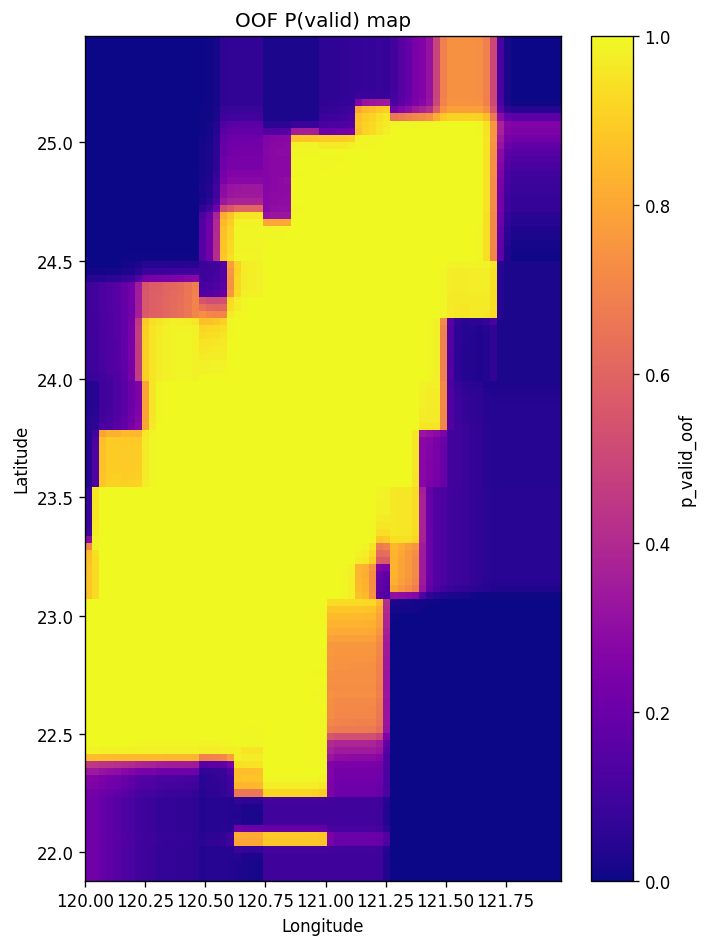

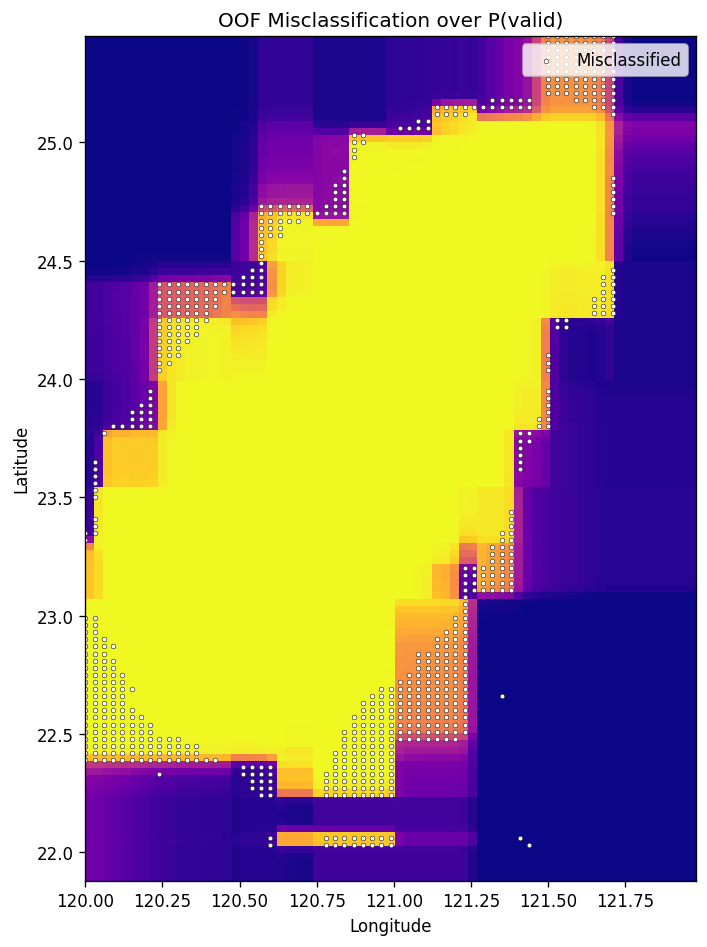

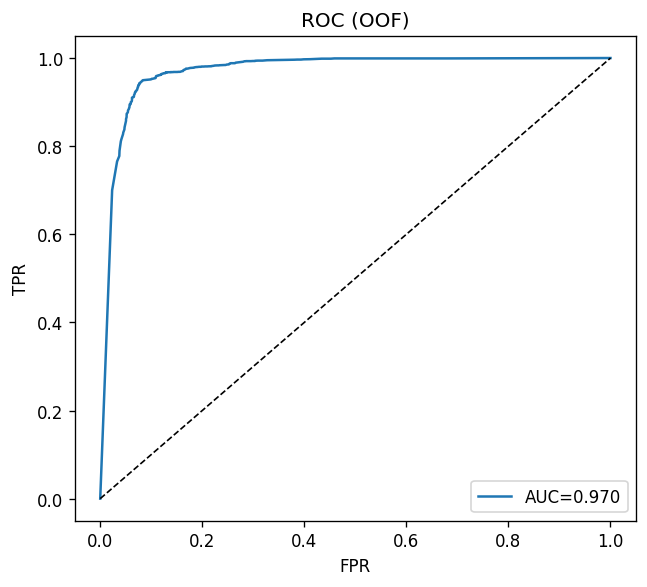

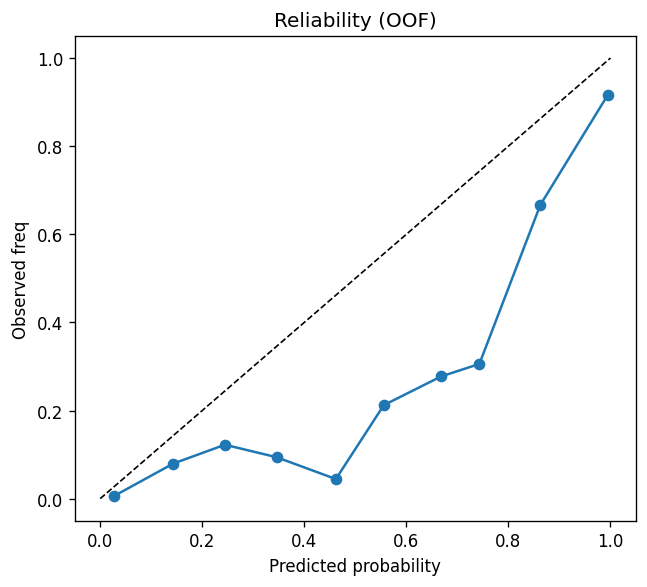

In [112]:
oof_proba = np.zeros(len(df_cls), dtype=float)
for fold, (tr, te) in enumerate(gkf.split(Xc, yc, groups=groups_c), 1):
    m = clone(best_clf)  # 用同類型模型與參數，但只用本折訓練
    m.fit(Xc[tr], yc[tr])
    if hasattr(m, "predict_proba"):
        oof_proba[te] = m.predict_proba(Xc[te])[:,1]
    elif hasattr(m, "decision_function"):
        s = m.decision_function(Xc[te]); oof_proba[te] = 1/(1+np.exp(-s))
    else:
        oof_proba[te] = m.predict(Xc[te])

oof_pred = (oof_proba >= 0.5).astype(int)
acc = accuracy_score(yc, oof_pred)
auc = roc_auc_score(yc, oof_proba)
f1  = f1_score(yc, oof_pred)
cm  = confusion_matrix(yc, oof_pred)
print(f"[OOF/CLS] ACC={acc:.3f}  AUC={auc:.3f}  F1={f1:.3f}")
print("Confusion matrix (OOF):\n", cm)

df_cls_oof = df_cls.copy()
df_cls_oof["p_valid_oof"] = oof_proba
df_cls_oof["pred_oof"]    = oof_pred
df_cls_oof.to_csv("classification_oof.csv", index=False)
print("Saved classification_oof.csv")

# 影像：OOF P(valid) 與誤判點
grid_image(df_cls_oof, "p_valid_oof", "OOF P(valid) map", vmin=0, vmax=1, cmap="plasma")
bg = (df_cls_oof.pivot_table(index="lat", columns="lon", values="p_valid_oof", aggfunc="mean")
                  .sort_index(axis=0).sort_index(axis=1))
extent = [bg.columns.min(), bg.columns.max(), bg.index.min(), bg.index.max()]
plt.figure(figsize=(6,8))
plt.imshow(bg.values, origin="lower", extent=extent, aspect="auto", vmin=0, vmax=1, cmap="plasma")
wrong = df_cls_oof[df_cls_oof["pred_oof"] != df_cls_oof["label"]]
plt.scatter(wrong["lon"], wrong["lat"], s=8, color="white", edgecolors="black", linewidths=0.3, label="Misclassified")
plt.legend(loc="upper right"); plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("OOF Misclassification over P(valid)"); plt.tight_layout(); plt.show()

# ROC 與校準（OOF）
fpr, tpr, _ = roc_curve(yc, oof_proba)
plt.figure(figsize=(5.5,5))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1],[0,1],'k--',lw=1); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (OOF)")
plt.legend(); plt.tight_layout(); plt.show()

prob_true, prob_pred = calibration_curve(yc, oof_proba, n_bins=10, strategy='uniform')
plt.figure(figsize=(5.5,5))
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("Predicted probability"); plt.ylabel("Observed freq"); plt.title("Reliability (OOF)")
plt.tight_layout(); plt.show()

[OOF/REG] MAE=2.593  RMSE=3.862  R2=0.607
Saved regression_oof.csv


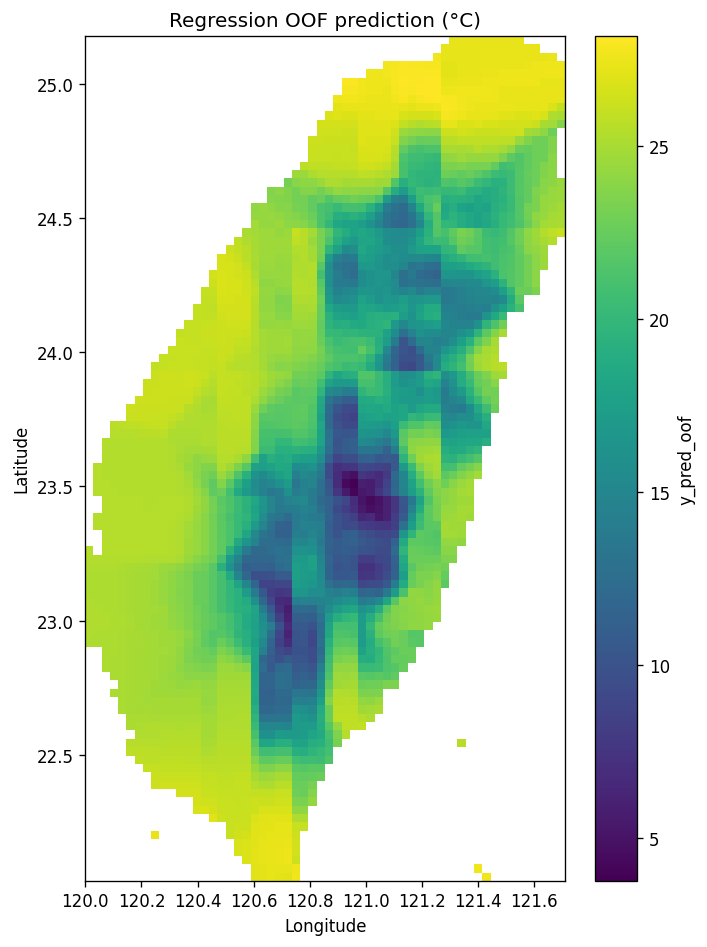

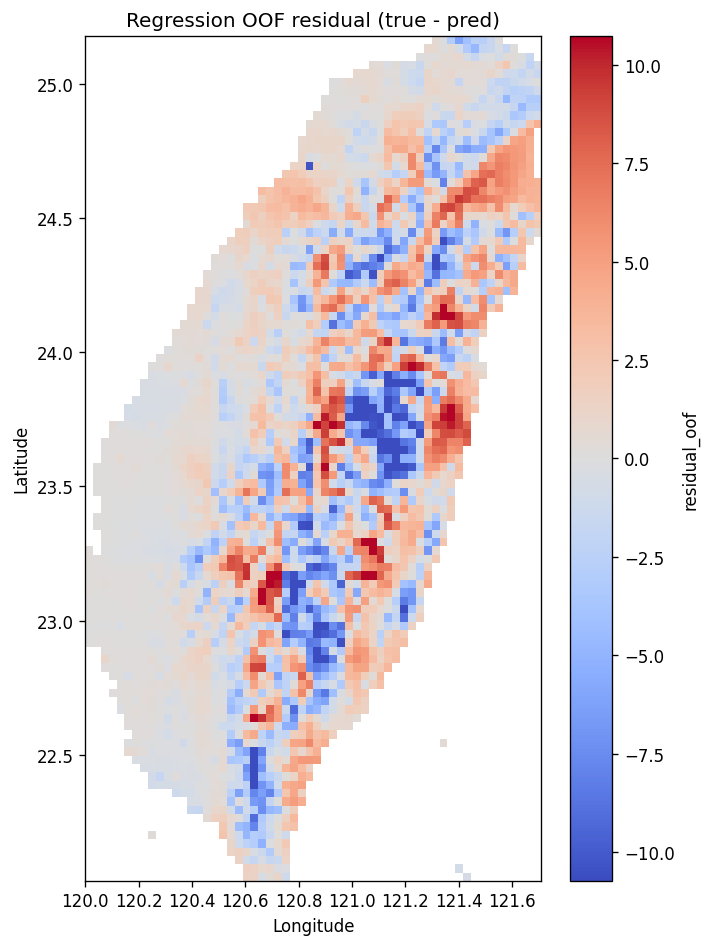

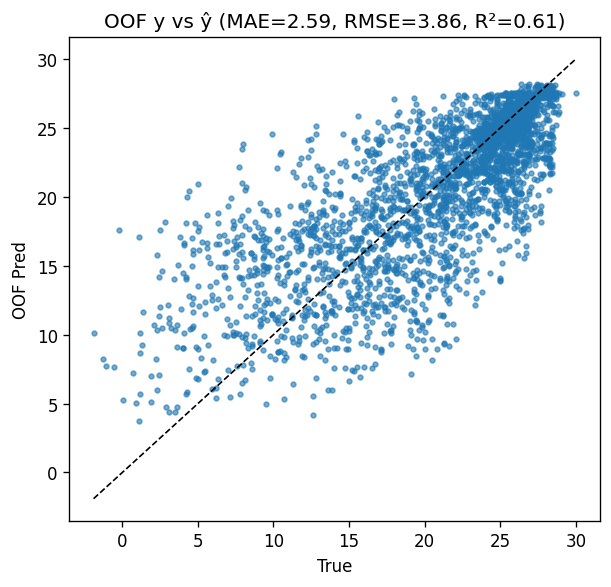

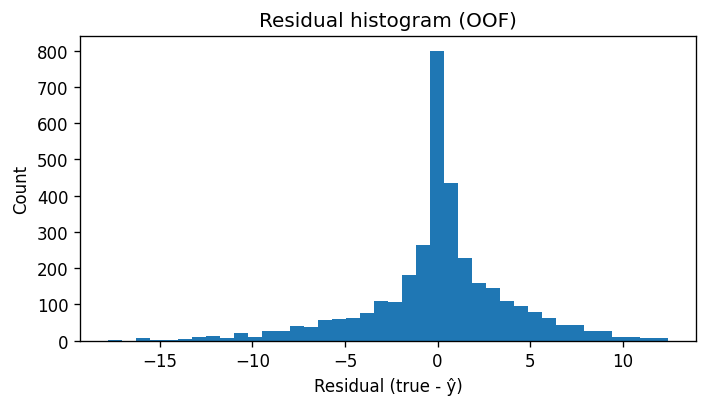

In [113]:
oof_pred_r = np.zeros(len(df_reg), dtype=float)
for fold, (tr, te) in enumerate(gkf.split(Xr, yr, groups=groups_r), 1):
    m = clone(best_reg)
    m.fit(Xr[tr], yr[tr])
    oof_pred_r[te] = m.predict(Xr[te])

mae = mean_absolute_error(yr, oof_pred_r)
rmse = rmse(yr, oof_pred_r)
r2  = r2_score(yr, oof_pred_r)
print(f"[OOF/REG] MAE={mae:.3f}  RMSE={rmse:.3f}  R2={r2:.3f}")

df_reg_oof = df_reg.copy()
df_reg_oof["y_pred_oof"] = oof_pred_r
df_reg_oof["residual_oof"] = df_reg_oof["value"] - df_reg_oof["y_pred_oof"]
df_reg_oof.to_csv("regression_oof.csv", index=False)
print("Saved regression_oof.csv")

# 影像：OOF 預測與殘差
grid_image(df_reg_oof, "y_pred_oof", "Regression OOF prediction (°C)")
vmax = np.percentile(np.abs(df_reg_oof["residual_oof"]), 98)
grid_image(df_reg_oof, "residual_oof", "Regression OOF residual (true - pred)", vmin=-vmax, vmax=vmax, cmap="coolwarm")

# y vs ŷ（OOF）
plt.figure(figsize=(5.2,5))
plt.scatter(df_reg_oof["value"], df_reg_oof["y_pred_oof"], s=8, alpha=0.6)
lims = [min(df_reg_oof["value"].min(), df_reg_oof["y_pred_oof"].min()),
        max(df_reg_oof["value"].max(), df_reg_oof["y_pred_oof"].max())]
plt.plot(lims, lims, 'k--', lw=1)
plt.xlabel("True"); plt.ylabel("OOF Pred"); plt.title(f"OOF y vs ŷ (MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.2f})")
plt.tight_layout(); plt.show()

# 殘差直方圖（OOF）
plt.figure(figsize=(6,3.5))
plt.hist(df_reg_oof["residual_oof"], bins=40)
plt.xlabel("Residual (true - ŷ)"); plt.ylabel("Count"); plt.title("Residual histogram (OOF)")
plt.tight_layout(); plt.show()
